In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [103]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1 # if variables are 0 it can mask a correct implementation of the gradient. When everything is 0 it simplifies and gets a much simpler expression of the gradient.

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

In [22]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [23]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv  # implicit broadcast
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.5025, grad_fn=<NegBackward0>)

In [ ]:
# loss = -(a + b + c) / 3
# dloss / d? = -1/n

In [ ]:
counts.shape, counts_sum_inv.shape
# c = a * b
# a[3x3] * b[3x1] --> c[3x3]
# a11*b1 a12*b1 a13*b1  b1 feeding into various branches --> if a node is used multiple times the gradients of all of its uses sum
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3

In [ ]:
# a11 a12 a13 -- > b1 (=a11 + a12 + a13)   (1 + 1 + 1)
# a21 a22 a23 -- > b2 (=a21 + a22 + a23)   the derivative of b2 is flowing horizontally to all of the components
# a31 a32 a33 -- > b3 (=a31 + a32 + a33)
# addition is a router of gradient. Whatever gradient that comes from above, it just gets routed equally to all the elements that participate
counts.shape, counts_sum.shape

In [ ]:
# c11 c12 c13 = a11 a12 a13       b1 --> it gets repeated the same number of columns of matrix C and A
# c21 c22 c23 = a21 a22 a23   -   b2
# c31 c32 c33 = a31 a32 a33       b3
# c11 = a11 - b1 1
# c12 = a12 - b1 1
# c13 = a13 - b1 1
# c21 = a21 - b2 2
# c22 = a22 - b2 2
# c23 = a23 - b2 2
# c31 = a31 - b3 3
# c32 = a32 - b3 3
# c33 = a33 - b3 3   b's are broadcast so we have to do the additional sum
norm_logits.shape, logits.shape, logit_maxes.shape

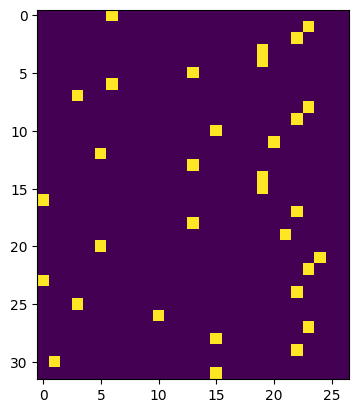

In [24]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

In [50]:
# emb = C[Xb] # embed the characters into vectors
# embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
C.shape, emb.shape, Xb.shape

(torch.Size([27, 10]), torch.Size([32, 3, 10]), torch.Size([32, 3]))

In [51]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n),Yb] = -1.0/n
dprobs = dlogprobs * (1.0 / probs)
# if counts_sum_inv was the replicated version dcounts_sum_inv = (counts * dprobs)
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # sum across horizontal direction and retain counts_sum_inv dimensions
dcounts = counts_sum_inv * dprobs # 1st branch
dcounts_sum = -counts_sum**-2 * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum # 2nd branch
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True) # I DONT UNDERSTAND YET WHY THE SUM
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnbias = dhpreact.sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = -0.5 * (bnvar + 1e-5)**-1.5 * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar # the broadcasting is doing the replication
dbndiff += (2 * bndiff) * dbndiff2
dbnmeani = (-dbndiff).sum(0, keepdim=True)
dhprebn = dbndiff.clone()
dhprebn += (1/n) * torch.ones_like(hprebn) * dbnmeani
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix, :] += demb[k,j] # the same row could have been used many times

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

In [54]:
# backward pass

dlogits = F.softmax(logits, 1) # do softmax along the rows
dlogits[range(n), Yb] -= 1 # subtract 1 at the correct position(label) for each example
dlogits /= n # average of all the losses, gradient needs to be scaled

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 6.51925802230835e-09


In [55]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [56]:
F.softmax(logits, 1)[0]

tensor([0.0378, 0.0166, 0.0274, 0.0253, 0.0426, 0.0613, 0.0804, 0.0209, 0.0373,
        0.0364, 0.0314, 0.0303, 0.0433, 0.0595, 0.0591, 0.0626, 0.0553, 0.0178,
        0.0243, 0.0292, 0.0399, 0.0124, 0.0214, 0.0277, 0.0324, 0.0286, 0.0388],
       grad_fn=<SelectBackward0>)

In [57]:
dlogits[0] * n

tensor([ 0.0378,  0.0166,  0.0274,  0.0253,  0.0426,  0.0613,  0.0804,  0.0209,
         0.0373,  0.0364,  0.0314,  0.0303,  0.0433,  0.0595,  0.0591,  0.0626,
         0.0553,  0.0178, -0.9757,  0.0292,  0.0399,  0.0124,  0.0214,  0.0277,
         0.0324,  0.0286,  0.0388], grad_fn=<MulBackward0>)

In [60]:
dlogits[0].sum()

tensor(-9.3132e-10, grad_fn=<SumBackward0>)

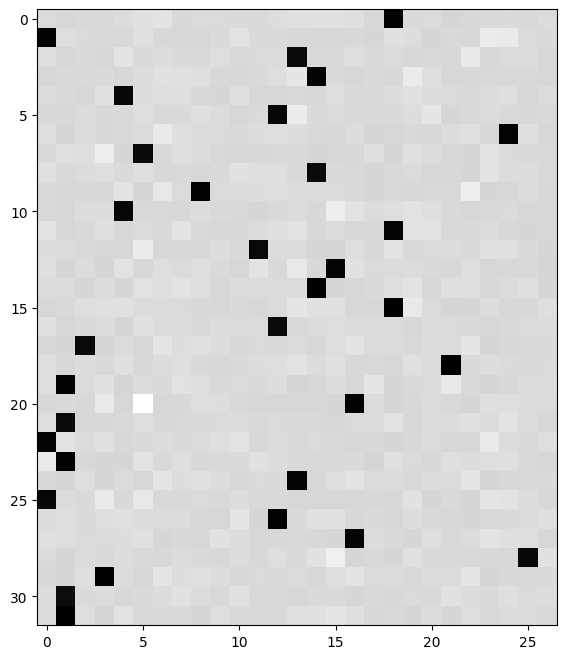

In [59]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

In [61]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [69]:
hprebn.shape, hpreact.shape, hpreact.sum(0).shape, bnraw.shape

(torch.Size([32, 64]),
 torch.Size([32, 64]),
 torch.Size([64]),
 torch.Size([32, 64]))

In [68]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0, keepdim=True) - (n/(n-1) * bnraw * (dhpreact * bnraw).sum(0, keepdim=True)))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [90]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
# kick off optimization
for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1) # do softmax along the rows
    dlogits[range(n), Yb] -= 1 # subtract 1 at the correct position(label) for each example
    dlogits /= n # average of all the losses, gradient needs to be scaled
    # 2nd layer backprop
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    dh = dlogits @ W2.T
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0, keepdim=True) - (n/(n-1) * bnraw * (dhpreact * bnraw).sum(0, keepdim=True)))
    # 1st layer backprop
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix, :] += demb[k,j] # the same row could have been used many times
    
    #dc, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
        #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
        p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #if i >= 1000: # TODO: delete early breaking when you're ready to train the full net
    #    break

12297
      0/ 200000: 3.6603
  10000/ 200000: 2.4524
  20000/ 200000: 2.3466
  30000/ 200000: 2.0812
  40000/ 200000: 2.0424
  50000/ 200000: 2.4629
  60000/ 200000: 2.3185
  70000/ 200000: 2.0608
  80000/ 200000: 1.9473
  90000/ 200000: 2.0369
 100000/ 200000: 2.4279
 110000/ 200000: 2.2282
 120000/ 200000: 2.1344
 130000/ 200000: 2.4497
 140000/ 200000: 2.2481
 150000/ 200000: 2.3993
 160000/ 200000: 2.2185
 170000/ 200000: 1.9795
 180000/ 200000: 2.3408
 190000/ 200000: 1.9266


In [91]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
    cmp(str(tuple(p.shape)), g, p)

TypeError: all() received an invalid combination of arguments - got (bool), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, tuple of ints dim, bool keepdim, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, Tensor out)
 * (Tensor input, name dim, bool keepdim, *, Tensor out)


In [98]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [99]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.072636127471924
val 2.1128201484680176


In [ ]:
# Pytorch results
#train 2.0686187744140625
#val 2.1115527153015137
# Manual backprop results
#train 2.072636127471924
#val 2.1128201484680176

In [100]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # ------------
        # forward pass:
        # Embedding
        emb = C[torch.tensor([context])] # (1,block_size,d)      
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        # ------------
        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mora.
mayanna.
elvedhayla.
remmadiendraegan.
chedieliah.
milopaleigh.
van.
nar.
katella.
kalin.
shubergshimiel.
kindreelynn.
novana.
ura.
geder.
yarulyehsyn.
ajaysen.
daihaan.
alynn.
juluna.


In [ ]:
# Pytorch examples
#mora.
#mayannieel.
#nduryal.
#remman.
#endraege.
#zered.
#eliah.
#milopaleigh.
#sananarielle.
#malaia.
#noshubergihimie.
#trick.
#welle.
#jose.
#casund.
#geder.
#yarleyeks.
#kaysh.
#samyah.
#hal.
# Manual backprop examples
mora.
mayanna.
elvedhayla.
remmadiendraegan.
chedieliah.
milopaleigh.
van.
nar.
katella.
kalin.
shubergshimiel.
kindreelynn.
novana.
ura.
geder.
yarulyehsyn.
ajaysen.
daihaan.
alynn.
juluna.